In [2]:
from IPython.display import display
import matplotlib.pyplot as plt

%matplotlib inline
import numpy as np
import os
import shutil
import wfdb
import collections
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

# S

# Reading the LUDB records

In [21]:
record_names = list(range(1,201))

for record_name in record_names:

    # Read the record and get the signal data
    record = wfdb.rdrecord(f'data/{record_name}')
    data = record.p_signal
    channel_names = record.sig_name

    # Save the data to a CSV file
    np.savetxt(f'{record_name}' + '.csv', data, delimiter=',')


In [38]:
# Extract the dataframe from a given record
# Each column is a lead
# Each row is 1/500 of a second for a total of 10 seconds of data
def record_as_df(record_name):
    record_df = pd.read_csv(f'data_csvs/{record_name}.csv', header=None)
    record_df.columns = channel_names
    return(record_df)

In [4]:
characteristics = pd.read_csv('characteristics.csv')
characteristics.head()

,Unnamed: 0,ID,Sex,Age,Rhythms,Electric axis of the heart,Conduction abnormalities,Extrasystolies,Hypertrophies,Cardiac pacing,Ischemia,Non-specific repolarization abnormalities,Other states
0,0,1,F\n,51\n,Sinus bradycardia,Electric axis of the heart: left axis deviation,NaN,NaN,Left ventricular overload\nLeft ventricular hy...,NaN,NaN,Non-specific repolarization abnormalities: pos...,NaN
1,1,2,M\n,64\n,Sinus rhythm,Electric axis of the heart: normal,NaN,NaN,Left atrial hypertrophy\nLeft ventricular hype...,NaN,NaN,Non-specific repolarization abnormalities: pos...,NaN
2,2,3,M\n,53\n,Sinus rhythm,Electric axis of the heart: vertical,NaN,NaN,Left atrial hypertrophy\nLeft ventricular hype...,NaN,Ischemia: inferior wall\nIschemia: lateral wall,NaN,NaN
3,3,4,M\n,56\n,Sinus rhythm,Electric axis of the heart: left axis deviation,Incomplete right bundle branch block,NaN,Left atrial hypertrophy\nLeft ventricular hype...,NaN,Ischemia: inferior wall\nScar formation: infer...,NaN,NaN
4,4,5,M\n,61\n,Sinus rhythm,Electric axis of the heart: horizontal,NaN,NaN,Left atrial hypertrophy,NaN,NaN,Non-specific repolarization abnormalities: inf...,NaN


In [101]:
characteristics.to_csv('characteristics.csv')

In [86]:
def annotations_as_df(record_name):
    annotation_df = record_as_df(record_name)
    for lead in annotation_df.columns:
        annotation = wfdb.rdann(f'data/{record_name}', lead)
        samples = annotation.sample
        symbols = annotation.symbol
        
        index = 0
        new_col = []
        for row in range(5000):
            if row in samples:
                new_col.append(symbols[index])
                index = index + 1
            else:
                new_col.append(np.nan)
        annotation_df[lead] = new_col
        
    return(annotation_df)

In [100]:
## SAVE THE CSVs for the manual annotations!

record_names = list(range(1,201))

for record_name in record_names:

    # Read the record and get the signal data
    adf = annotations_as_df(record_name)
    adf = adf.dropna(how='all')
    
    # Save the data to a CSV file
    adf.to_csv(f'~/Project/annotation_csvs/{record_name}.csv')


# EDA of LUDB Dataset

In [42]:
from sklearn.preprocessing import MinMaxScaler

In [40]:
# Just looking at a couple of records to check them out
df = record_as_df(1)
df.describe()

,i,ii,iii,avr,avl,avf,v1,v2,v3,v4,v5,v6
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.000389,0.000398,0.000661,0.000226,0.000246,0.000020,0.000568,0.000072,0.000035,0.000039,0.000480,0.000341
std,0.106820,0.095866,0.072465,0.107107,0.096558,0.068033,0.101290,0.127703,0.106190,0.095174,0.099589,0.103561
min,-0.109557,-0.135987,-0.778682,-0.886696,-0.114766,-0.368195,-0.804665,-0.395674,-0.245684,-0.198964,-0.116201,-0.096774
25%,-0.027972,-0.026534,0.004068,0.002924,-0.027778,-0.020057,-0.015306,-0.058524,-0.043382,-0.036254,-0.031823,-0.035003
50%,-0.018065,-0.014096,0.012205,0.018275,-0.017544,-0.002865,-0.006560,-0.047074,-0.036742,-0.027190,-0.022662,-0.019218
75%,-0.006410,0.004975,0.021969,0.028509,-0.008772,0.015759,0.029883,-0.015267,-0.015494,-0.007337,-0.005304,0.004118
max,0.890443,0.864013,0.221318,0.113304,0.885234,0.631805,0.195335,0.604326,0.754316,0.801036,0.883799,0.903226


In [41]:
df = record_as_df(2)
df.describe()

,i,ii,iii,avr,avl,avf,v1,v2,v3,v4,v5,v6
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.000924,0.000094,0.000568,0.000636,0.000168,0.000188,0.000335,0.000134,0.000688,0.000269,0.000020,0.000344
std,0.091278,0.084222,0.078780,0.091451,0.101627,0.078696,0.099312,0.134277,0.107571,0.090395,0.104016,0.109491
min,-0.320106,-0.250702,-0.400283,-0.727162,-0.551163,-0.274556,-0.673745,-0.685063,-0.696456,-0.302288,-0.196464,-0.150794
25%,-0.046296,-0.038354,-0.028289,-0.014616,-0.046512,-0.031953,-0.004505,-0.033848,-0.043143,-0.037582,-0.050426,-0.046737
50%,-0.022487,-0.016838,-0.004243,0.020706,-0.018605,-0.010651,0.007722,-0.005887,-0.018490,-0.020697,-0.019646,-0.027337
75%,0.031746,0.013096,0.019802,0.046285,0.039535,0.017751,0.032175,0.043414,0.023883,0.000545,0.006549,0.005291
max,0.679894,0.749298,0.599717,0.272838,0.448837,0.725444,0.326255,0.314937,0.303544,0.697712,0.803536,0.849206


## Summarizing Breakdown of Characteristics

In [5]:
characteristics.columns

Index(['Unnamed: 0', 'ID', 'Sex', 'Age', 'Rhythms',
       'Electric axis of the heart', 'Conduction abnormalities',
       'Extrasystolies', 'Hypertrophies', 'Cardiac pacing', 'Ischemia',
       'Non-specific repolarization abnormalities', 'Other states'],
      dtype='object')

In [117]:
# Terms indicating "normal" conditions
normal_condition = ['Electric axis of the heart: normal', 'Sinus rhythm', ]

In [131]:
non_diagnoses=['Sex', 'Age', 'Cardiac pacing']
diagnoses=['Rhythms','Electric axis of the heart', 'Conduction abnormalities', 'Extrasystolies', 
               'Hypertrophies', 'Ischemia', 'Non-specific repolarization abnormalities', 'Other states']


In [123]:
bin_characteristics = (characteristics == normal_condition[0]) | (characteristics == normal_condition[1]) | (characteristics.isna())

In [127]:
agg_chars = bin_characteristics.aggregate(['sum','count'])
agg_chars

,Unnamed: 0,ID,Sex,Age,Rhythms,Electric axis of the heart,Conduction abnormalities,Extrasystolies,Hypertrophies,Cardiac pacing,Ischemia,Non-specific repolarization abnormalities,Other states
sum,0,0,0,0,142,85,134,186,58,190,149,151,191
count,200,200,200,200,200,200,200,200,200,200,200,200,200


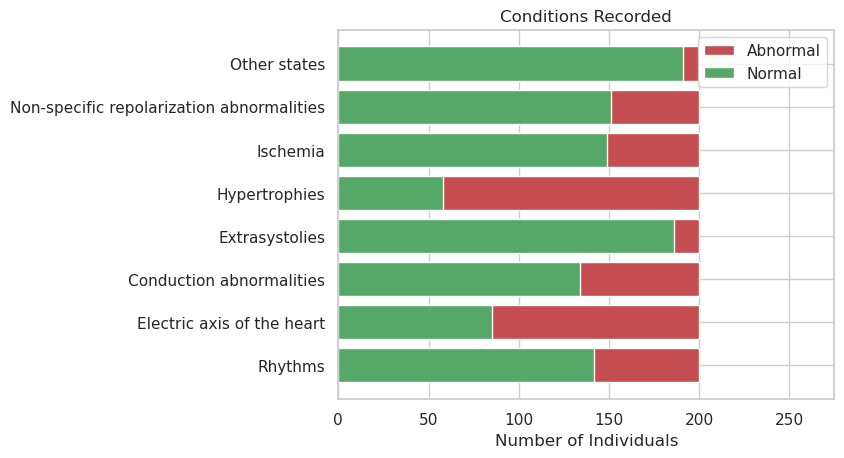

In [203]:
fig,ax=plt.subplots()
ax.grid(alpha=1,zorder=0)
ax.barh(y=diagnoses, width=200, label='Abnormal', color='r',zorder=2)
ax.barh(y=diagnoses, width=agg_chars.loc['sum',diagnoses], label='Normal',zorder=2, color='g')
ax.set_xlim(0,275)
ax.set_title('Conditions Recorded')
ax.set_xlabel('Number of Individuals')
ax.legend();

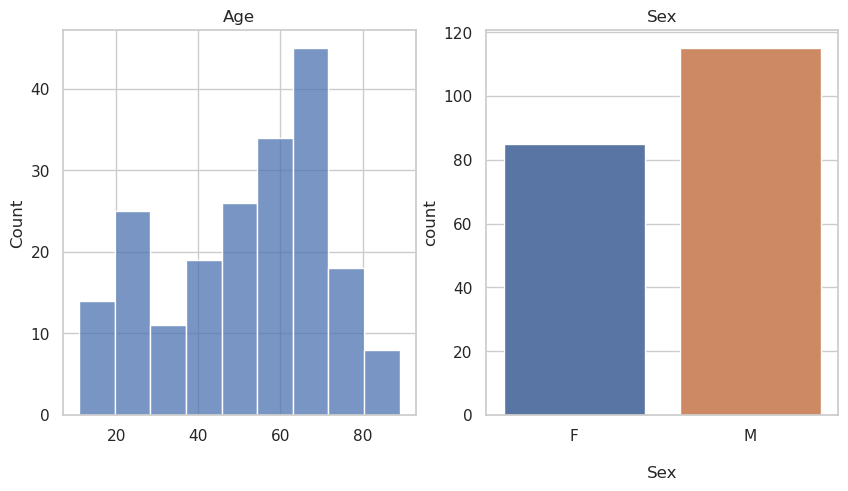

In [195]:
sns.set_theme(style="whitegrid")
fig,axs=plt.subplots(1,2, figsize=(10,5))
for i,char in enumerate(np.array(['Age','Sex'])):
    axs[i].set_title(char)
    if char == 'Age':
        sns.histplot(x=[int(x.strip('>\n')) for x in characteristics['Age']], ax=axs[i])
    else:
        sns.countplot(x=characteristics[char], ax=axs[i])
        
        

In [197]:
pacemaker=pd.Series(['None' if pd.isna(x) else x for x in characteristics['Cardiac pacing']]).value_counts()
pacemaker

None                                                                                  190
Pacemaker presence, undefined\nUnipolar ventricular pacing                              4
Pacemaker presence, undefined\nBipolar ventricular pacing                               2
Pacemaker presence, undefined\nUnipolar ventricular pacing\nUnipolar atrial pacing      1
P-synchrony                                                                             1
Pacemaker presence, undefined\nBiventricular pacing                                     1
Pacemaker presence, undefined\nP-synchrony\nUnipolar ventricular pacing                 1
dtype: int64

In [200]:
np.mean([int(x.strip('>\n')) for x in characteristics['Age']])

51.97

## Add lead name headers to subject-level CSVs 

In [7]:
# Get lead names in order
annot1 = pd.read_csv("annotation_csvs/1.csv")
leadnames = annot1.columns[1:]

In [ ]:
for x in range(1,201):
    path = f"data_csvs/{x}.csv"
    df = pd.read_csv(path, names=leadnames)
    df.to_csv(path)

## Group signals by lead type 

In [25]:
i = []
ii = []
iii = []
avr = []
avl = []
avf = []
v1 = []
v2 = []
v3 = []
v4 = []
v5 = []
v6 = []

for x in range(1,201):
    path = f"data_csvs/{x}.csv"
    df = pd.read_csv(path, index_col=0)
    i.append(df.i.values)
    ii.append(df.ii.values)
    iii.append(df.iii.values)
    avr.append(df.avr.values)
    avl.append(df.avl.values)
    avf.append(df.avf.values)
    v1.append(df.v1.values)
    v2.append(df.v2.values)
    v3.append(df.v3.values)
    v4.append(df.v4.values)
    v5.append(df.v5.values)
    v6.append(df.v6.values)

In [26]:
# Normalize with min-max scaling and save to csv
lead_data = [i, ii, iii, avr, avl, avf, v1, v2, v3, v4, v5, v6]
for k in range(12):
    lead_data[k] = MinMaxScaler().fit_transform(lead_data[k])
    pd.DataFrame(lead_data[k]).to_csv(f"lead_csvs/{leadnames[k]}.csv")

## PCA analysis of signals by lead type

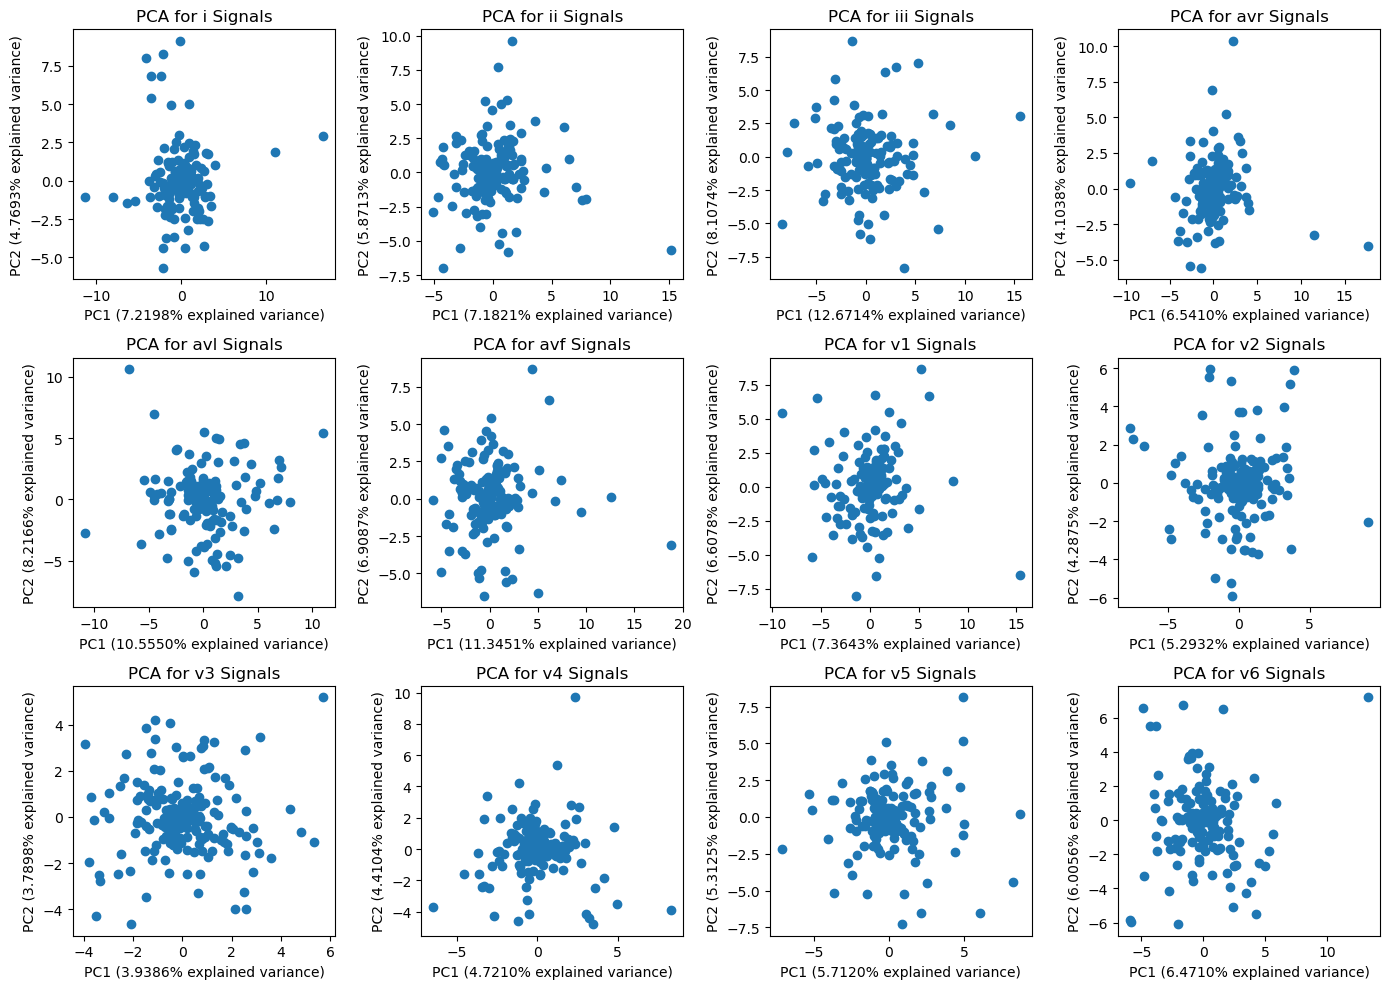

In [28]:
pca = PCA()
fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(14,10))
axs = ax.ravel()

for k in range(12):
    data = lead_data[k]
    PC = pca.fit_transform(data)
    var_exp = pca.explained_variance_ / sum(pca.explained_variance_)
    axs[k].plot(PC[:,0], PC[:,1],'o')
    axs[k].set_title(f"PCA for {leadnames[k]} Signals")
    axs[k].set_xlabel(f"PC1 ({100*var_exp[0]:1.4f}% explained variance)")
    axs[k].set_ylabel(f"PC2 ({100*var_exp[1]:1.4f}% explained variance)")
plt.tight_layout()
plt.savefig("signalPCA.png");

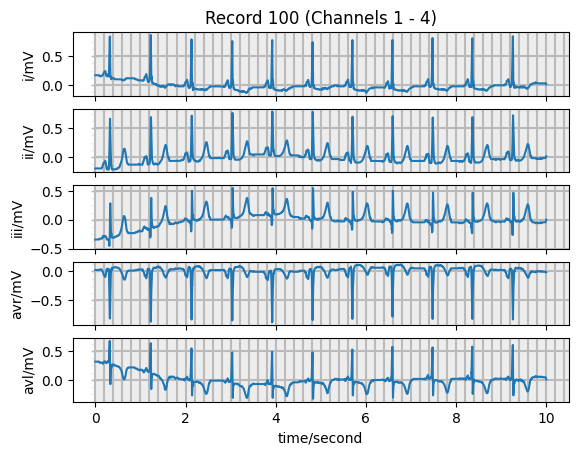

{'record_name': '100',
 'n_sig': 5,
 'fs': 500,
 'counter_freq': None,
 'base_counter': None,
 'sig_len': 5000,
 'base_time': None,
 'base_date': None,
 'comments': ['<age>: 76',
  '<sex>: F',
  '<diagnoses>:',
  'Rhythm: Sinus rhythm.',
  'Electric axis of the heart: normal.',
  'Left atrial hypertrophy.',
  'Left atrial overload.',
  'Left ventricular hypertrophy.',
  'Ischemia: anterior wall.',
  'Ischemia: lateral wall.'],
 'sig_name': ['i', 'ii', 'iii', 'avr', 'avl'],
 'p_signal': array([[ 0.17120281, -0.19676113, -0.34140625,  0.0249004 ,  0.31442786],
        [ 0.17120281, -0.19595142, -0.340625  ,  0.0249004 ,  0.31442786],
        [ 0.17120281, -0.19595142, -0.340625  ,  0.0249004 ,  0.31442786],
        ...,
        [ 0.02458297,  0.01052632, -0.0109375 , -0.0189243 ,  0.02089552],
        [ 0.0166813 ,  0.01295547, -0.0015625 , -0.01593625,  0.01094527],
        [ 0.01404741,  0.01376518,  0.0015625 , -0.01494024,  0.00696517]]),
 'd_signal': None,
 'e_p_signal': None,
 'e_d

In [3]:
record = wfdb.rdrecord("data/data/100", channels=[0, 1, 2, 3, 4])
wfdb.plot_wfdb(
    record=record,
    title="Record 100 (Channels 1 - 4)",
    time_units="seconds",
    ecg_grids="all",
)
display(record.__dict__)

In [4]:
data_recs = []
for i in range(1, 201):
    record = wfdb.rdrecord("data/data/" + str(i))
    data_recs.append(record)

data_recs[:3]

In [5]:
target = "Non-specific repolarization abnormalities"
labels = []

for data in data_recs:
    s = "".join(data.comments)
    if target in s:
        labels.append(1)
    else:
        labels.append(0)
labels[:10]

[1, 1, 0, 0, 1, 0, 0, 0, 1, 0]

Text(0.5, 1.0, 'Number of Conduction Abnormalities in LUDB Dataset')

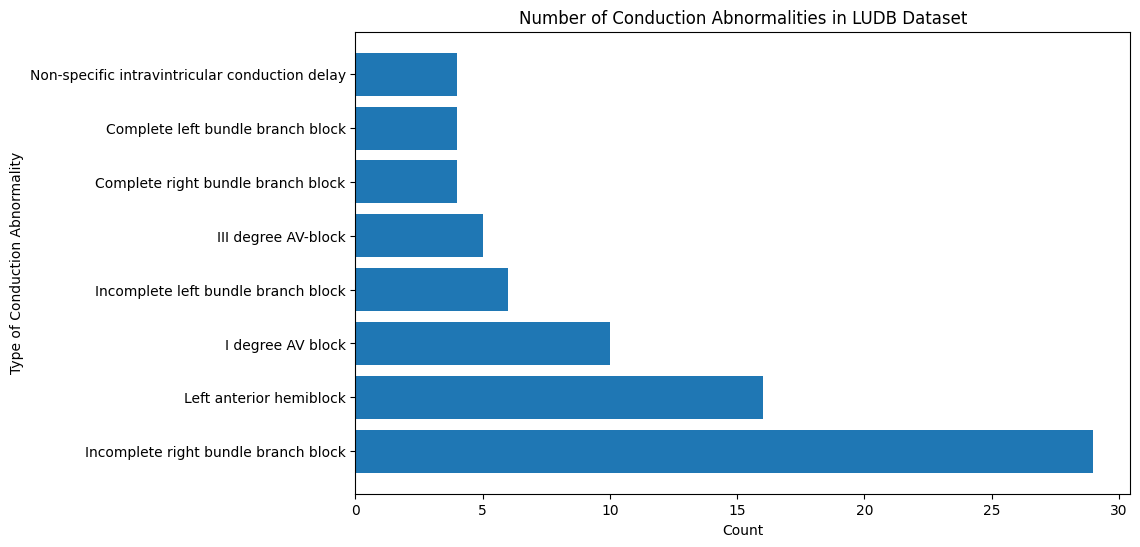

In [6]:
import collections

# Conduction Abnormalities
target_conditions = [
    "Sinoatrial blockade, undetermined",
    "I degree AV block",
    "III degree AV-block",
    "Incomplete right bundle branch block",
    "Incomplete left bundle branch block",
    "Left anterior hemiblock",
    "Complete right bundle branch block",
    "Complete left bundle branch block",
    "Non-specific intravintricular conduction delay",
]

condition_counts = collections.defaultdict(int)

for data in data_recs:
    s = "".join(data.comments)
    for condition in target_conditions:
        if condition in s:
            condition_counts[condition] += 1

sorted_counts = sorted(condition_counts.items(), key=lambda x: x[1], reverse=True)

plt.figure(figsize=(10, 6))
plt.barh([item[0] for item in sorted_counts], [item[1] for item in sorted_counts])
plt.xlabel("Count")
plt.ylabel("Type of Conduction Abnormality")
plt.title("Number of Conduction Abnormalities in LUDB Dataset")

Text(0.5, 1.0, 'Number of Hypertrophies in LUDB Dataset')

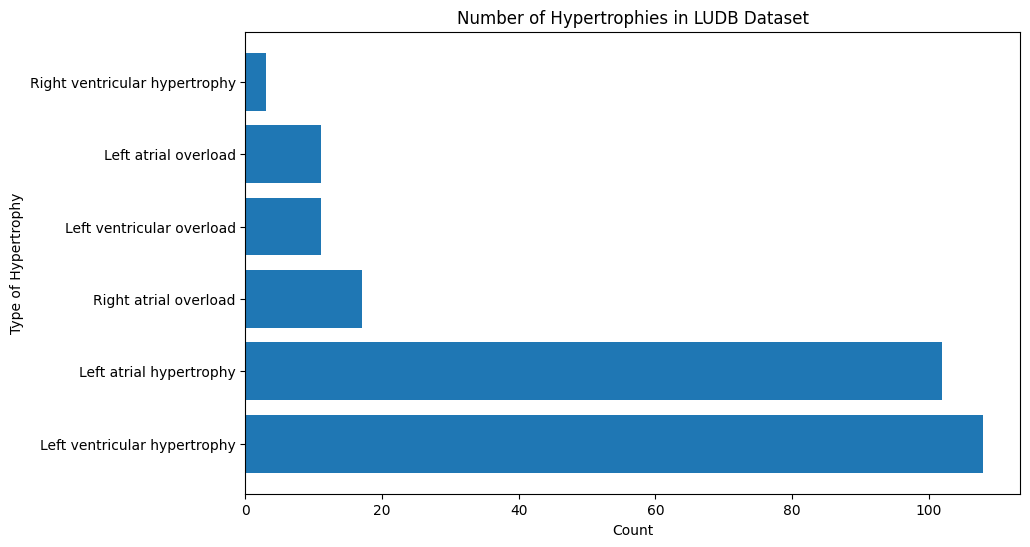

In [7]:
# Hypertrophies
target_conditions = [
    "Right atrial hypertropy",
    "Left atrial hypertrophy",
    "Right atrial overload",
    "Left atrial overload",
    "Left ventricular hypertrophy",
    "Right ventricular hypertrophy",
    "Left ventricular overload",
]

condition_counts = collections.defaultdict(int)

for data in data_recs:
    s = "".join(data.comments)
    for condition in target_conditions:
        if condition in s:
            condition_counts[condition] += 1

sorted_counts = sorted(condition_counts.items(), key=lambda x: x[1], reverse=True)

plt.figure(figsize=(10, 6))
plt.barh([item[0] for item in sorted_counts], [item[1] for item in sorted_counts])
plt.xlabel("Count")
plt.ylabel("Type of Hypertrophy")
plt.title("Number of Hypertrophies in LUDB Dataset")

Text(0.5, 1.0, 'Distribution of Signal Durations in LUDB Dataset')

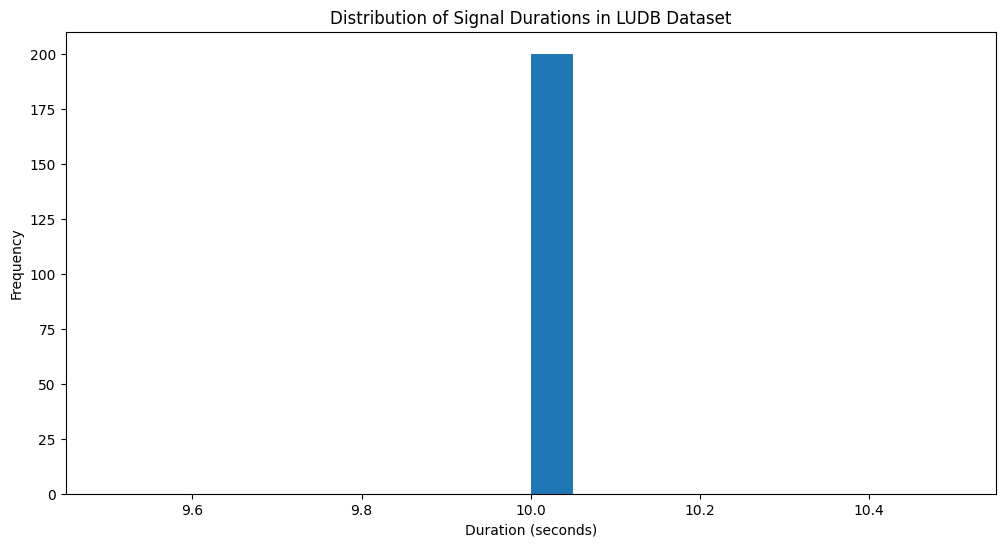

In [8]:
# Verifying the distribution of signal durations
durations = [data.sig_len / data.fs for data in data_recs]

plt.figure(figsize=(12, 6))
plt.hist(durations, bins=20)
plt.xlabel("Duration (seconds)")
plt.ylabel("Frequency")
plt.title("Distribution of Signal Durations in LUDB Dataset")

In [9]:
summary_stats = []

for data in data_recs:
    stats = {
        "mean": np.mean(data.p_signal, axis=0),
        "std": np.std(data.p_signal, axis=0),
        "min": np.min(data.p_signal, axis=0),
        "max": np.max(data.p_signal, axis=0),
    }
    summary_stats.append(stats)

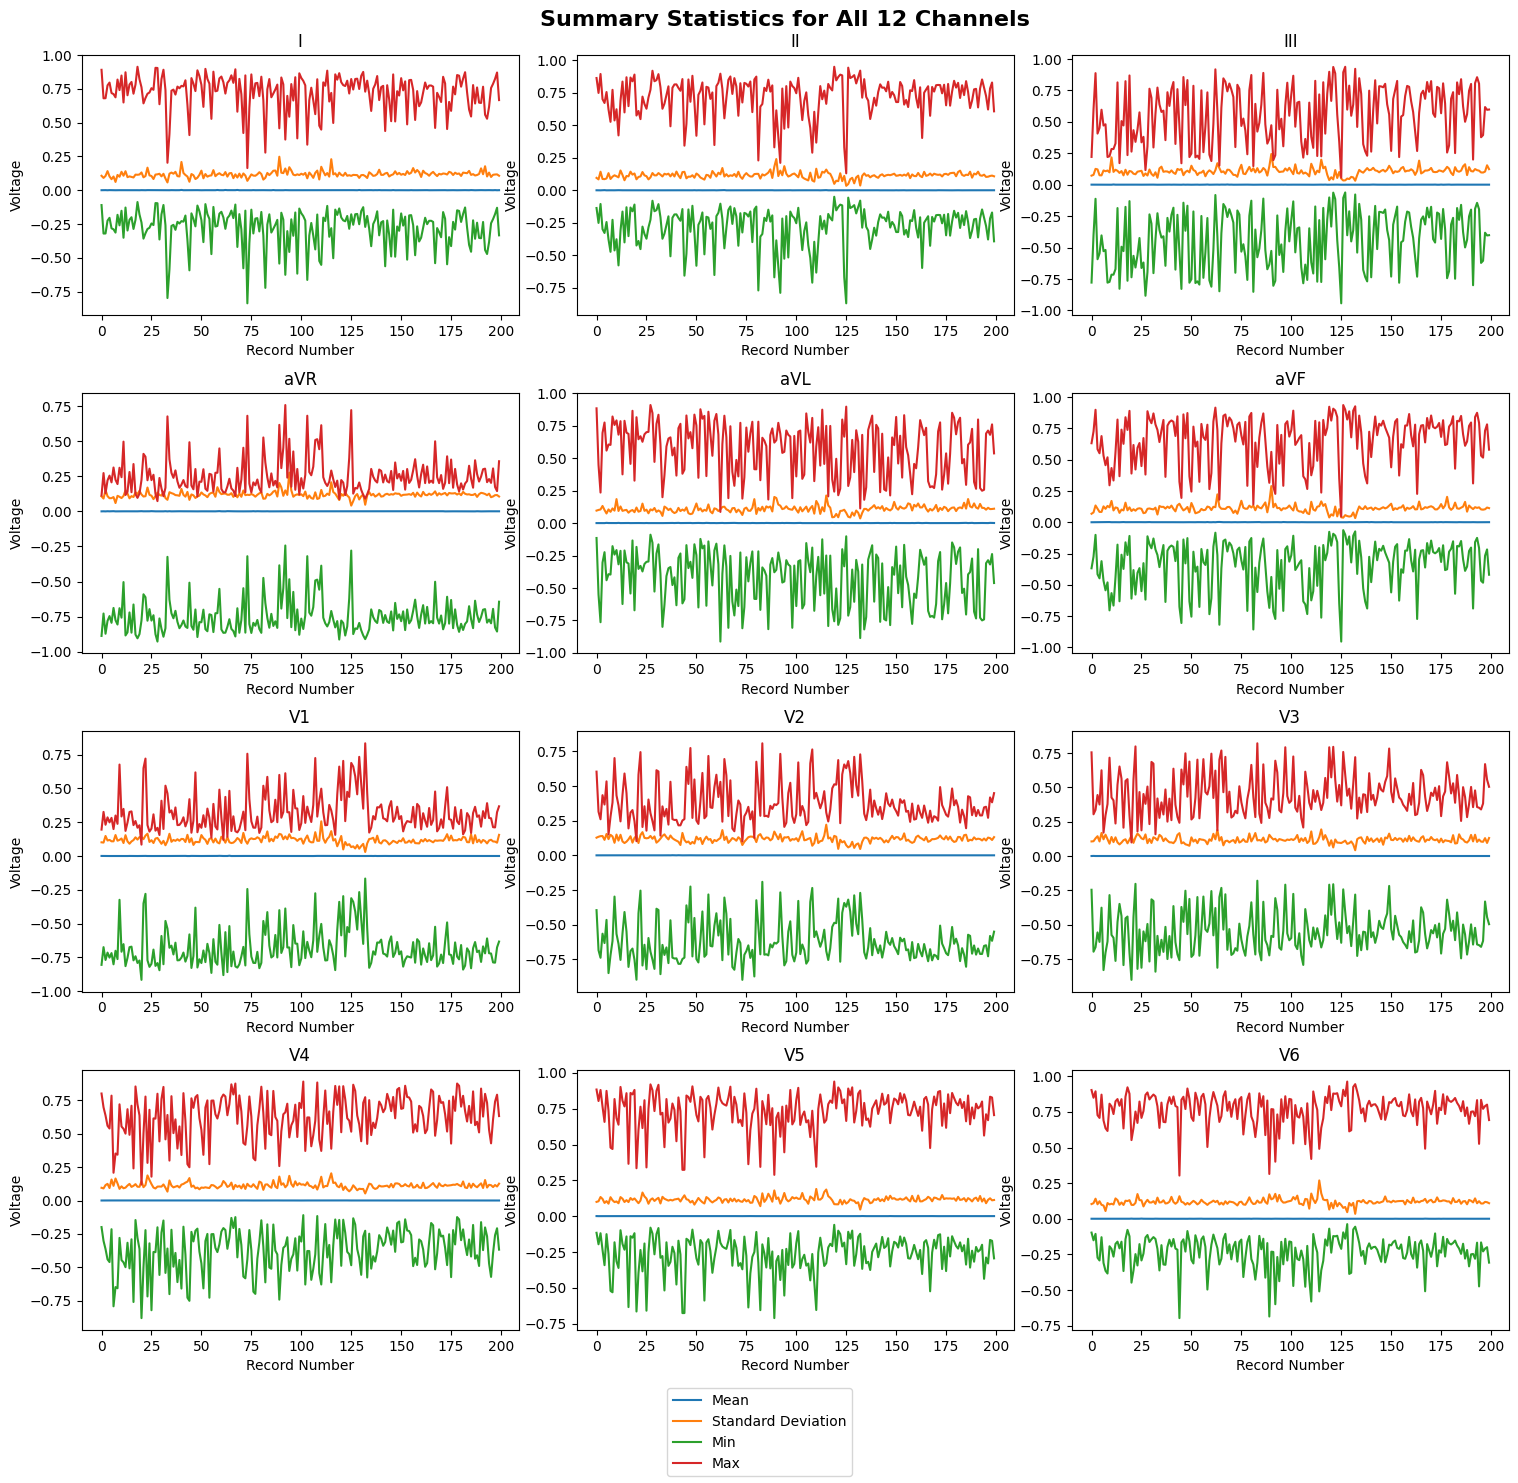

In [10]:
# Visualize summary stats for all 12 channels, 4 x 3
fig, axes = plt.subplots(4, 3, figsize=(15, 15))
plt.tight_layout()
plt.subplots_adjust(hspace=0.3)
for i, channel in enumerate(
    ["I", "II", "III", "aVR", "aVL", "aVF", "V1", "V2", "V3", "V4", "V5", "V6"]
):
    ax = axes[i // 3, i % 3]
    ax.plot([stats["mean"][i] for stats in summary_stats], label="Mean")
    ax.plot([stats["std"][i] for stats in summary_stats], label="Standard Deviation")
    ax.plot([stats["min"][i] for stats in summary_stats], label="Min")
    ax.plot([stats["max"][i] for stats in summary_stats], label="Max")
    ax.set_xlabel("Record Number")
    ax.set_ylabel("Voltage")
    ax.set_title(channel)

    if i == 11:
        handles, labels = ax.get_legend_handles_labels()
        fig.legend(handles, labels, loc="lower center")

plt.subplots_adjust(bottom=0.1)
plt.suptitle("Summary Statistics for All 12 Channels", fontsize=16, fontweight="bold")
plt.subplots_adjust(top=0.95)

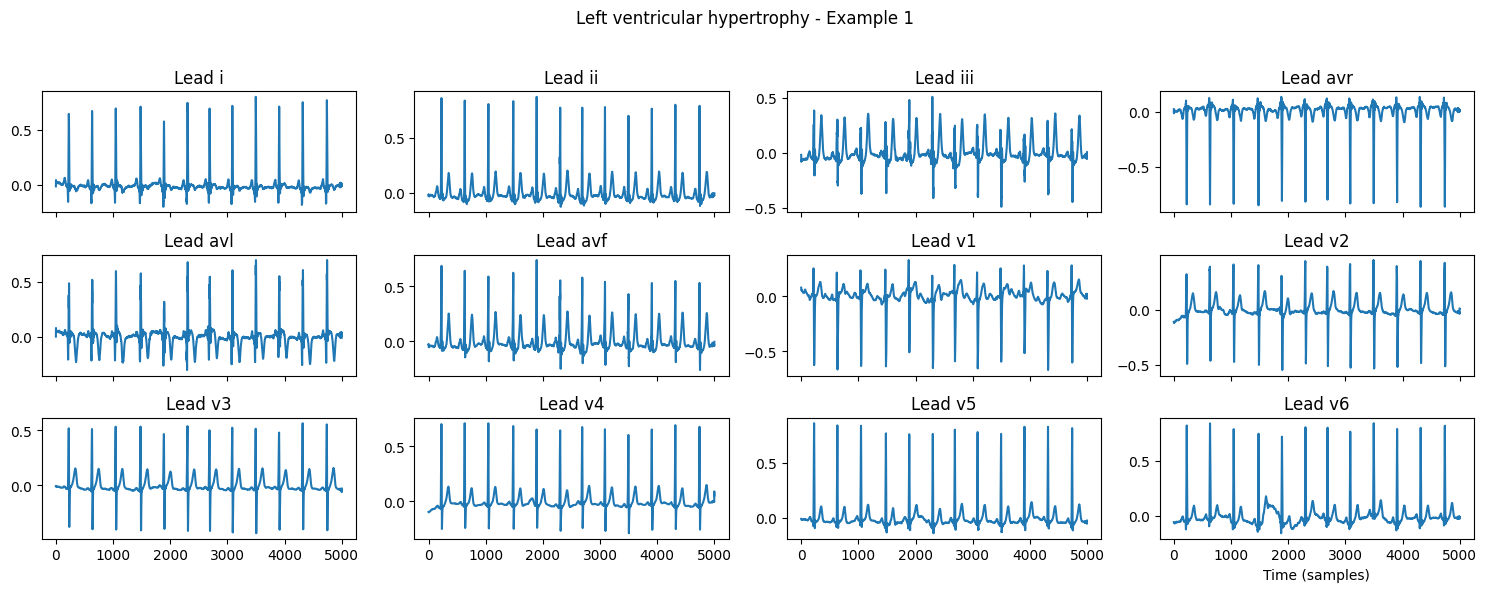

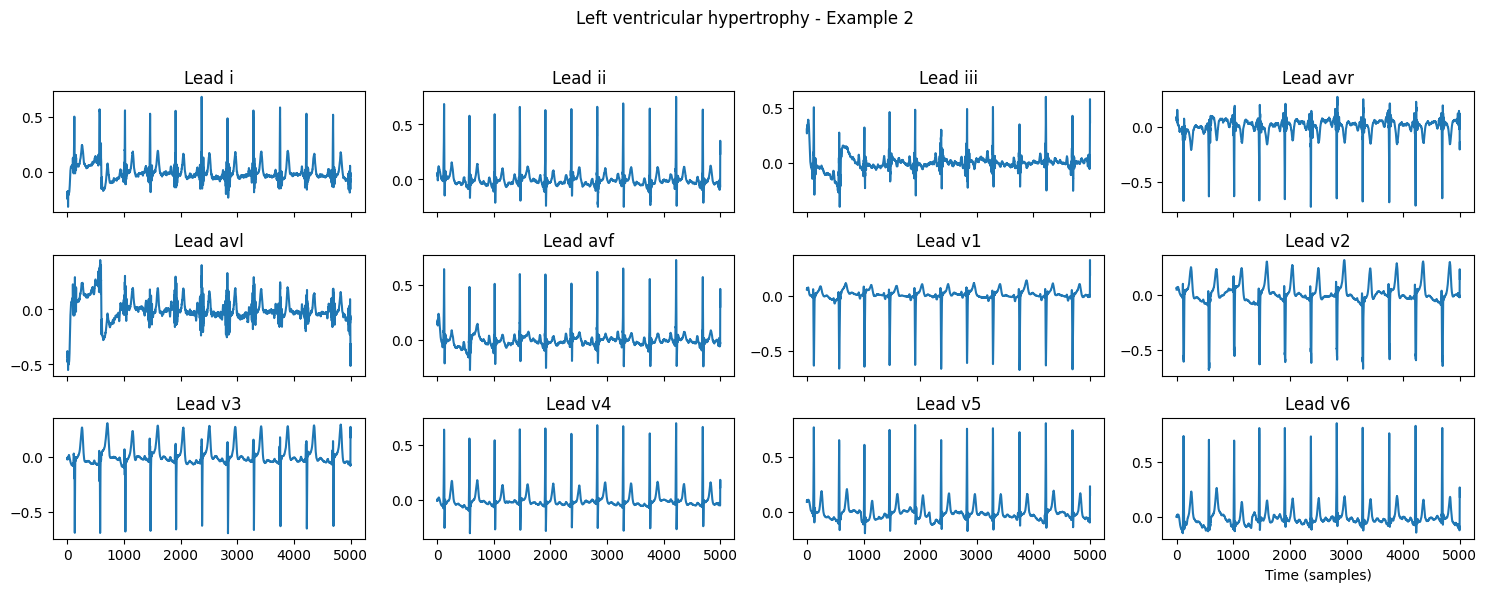

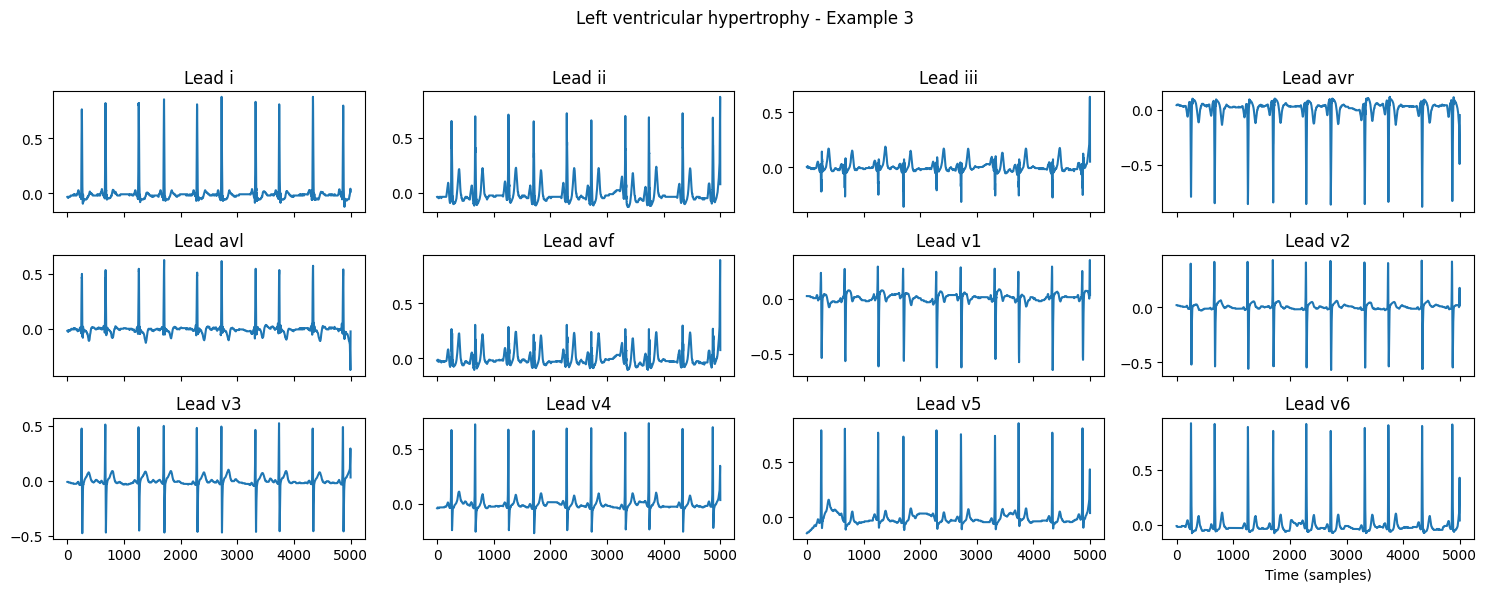

In [11]:
import random


# Visualize ECG signals for different conditions
def plot_random_ecg(records, condition, n_samples=3):
    condition_records = [
        record for record in records if condition in "".join(record.comments)
    ]
    selected_records = random.sample(condition_records, n_samples)

    for i, record in enumerate(selected_records):
        fig, axes = plt.subplots(3, 4, figsize=(15, 6), sharex=True)
        for j in range(12):
            axes[j // 4, j % 4].plot(record.p_signal[:, j])
            axes[j // 4, j % 4].set_title(f"Lead {record.sig_name[j]}")
        fig.suptitle(f"{condition} - Example {i+1}")
        plt.xlabel("Time (samples)")
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()


# Example usage
plot_random_ecg(data_recs, "Left ventricular hypertrophy")

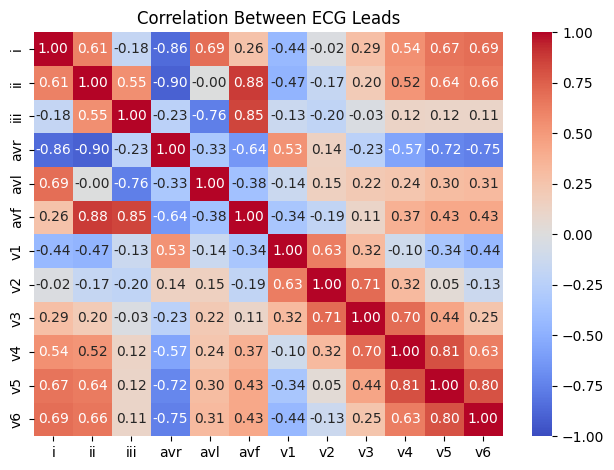

In [12]:
def get_lead_correlations(records):
    lead_signals = []

    for record in records:
        lead_signals.append(record.p_signal)

    lead_signals = np.vstack(lead_signals)
    return np.corrcoef(lead_signals.T)


lead_correlations = get_lead_correlations(data_recs)
sns.heatmap(
    lead_correlations,
    annot=True,
    xticklabels=record.sig_name,
    yticklabels=record.sig_name,
    cmap="coolwarm",
    center=0,
    vmin=-1,
    vmax=1,
    fmt=".2f",
)
plt.title("Correlation Between ECG Leads")
plt.tight_layout()

In [23]:
def create_features_and_labels(records, target_conditions):
    features = []
    labels = []
    
    for record in records:
        record_comments = ''.join(record.comments)
        features.append(record.p_signal.flatten())
        
        label = 0
        for condition in target_conditions:
            if condition in record_comments:
                label = 1
                break
                
        labels.append(label)
    
    return np.array(features), np.array(labels)

# Hypertrophies
target_conditions = [
    "Right atrial hypertropy",
    "Left atrial hypertrophy",
    "Right atrial overload",
    "Left atrial overload",
    "Left ventricular hypertrophy",
    "Right ventricular hypertrophy",
    "Left ventricular overload",
]

X, y = create_features_and_labels(data_recs, target_conditions)

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=109)


In [24]:
log_reg = LogisticRegression(max_iter=1000, random_state=109)
log_reg.fit(X_train, y_train)

y_pred_train = log_reg.predict(X_train)
y_pred_test = log_reg.predict(X_test)

print("Train accuracy:", accuracy_score(y_train, y_pred_train))
print("Test accuracy:", accuracy_score(y_test, y_pred_test))

print("\nTrain Classification Report:")
print(classification_report(y_train, y_pred_train))

print("\nTest Classification Report:")
print(classification_report(y_test, y_pred_test))

print("\nTrain Confusion Matrix:")
print(confusion_matrix(y_train, y_pred_train))

print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_test))


Train accuracy: 1.0
Test accuracy: 0.675

Train Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        48
           1       1.00      1.00      1.00       112

    accuracy                           1.00       160
   macro avg       1.00      1.00      1.00       160
weighted avg       1.00      1.00      1.00       160


Test Classification Report:
              precision    recall  f1-score   support

           0       0.29      0.20      0.24        10
           1       0.76      0.83      0.79        30

    accuracy                           0.68        40
   macro avg       0.52      0.52      0.51        40
weighted avg       0.64      0.68      0.65        40


Train Confusion Matrix:
[[ 48   0]
 [  0 112]]

Test Confusion Matrix:
[[ 2  8]
 [ 5 25]]
